<a href="https://colab.research.google.com/github/amazon4b/Learning-Machine/blob/learner1/%EA%B2%BD%EA%B8%B0%EB%B6%84%EC%84%9D%2Ck_means(k%3D4)%2Cmeanshift%2C_minmax%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import warnings

# 경고 메시지를 출력하지 않도록 설정
warnings.filterwarnings("ignore")

# 경고 메시지를 발생시키는 함수
def example_function():
    warnings.warn("이 함수는 예제일 뿐입니다.", UserWarning)

# 함수 호출
example_function()

In [4]:
# 기본패키지 설치
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans # 케이민즈 알고리즘
from sklearn.preprocessing import StandardScaler# 스텐다드 스케일러
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

In [5]:
# 데이터프레임 불러오기
economics = pd.read_csv('./datasets/resampled_data_final.csv',encoding="euc-kr")
economics['DATE'] = pd.to_datetime(economics['DATE'])
economics['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 289 entries, 0 to 288
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
287 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 KB


In [6]:
economics.drop(['장단기10년물국채/3개월금리차','신규실업수당청구','금융상태지수레버리지','제조업신규주문'],axis=1,inplace=True)

In [7]:
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매
287,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
economics = economics.iloc[:287 , ] # 결측치 제거
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,M2통화량,경기동행종합,산업생산지수,소매판매


In [9]:
# 2000년~2019년만 군집화하기 위함 , 코로나 데이터가 이상치로 잡히기 때문에 군집이 제대로 형성되지 않음
economics = economics.loc[economics['DATE'].dt.year <=2019 ]

In [10]:
# 주택가격지수. 제조업신규주문 , 경기동행종합지수는 차분하고 (변동치로 변경한다는 뜻)
# 제조업 신규주문은 앞으로 어떻게 처리할지 일단 보류
#M2와 소매판매는 변화율로 바꾸는 전처리 시행
economics.주택가격지수 = economics.주택가격지수.diff().fillna(method= 'bfill')
economics.경기동행종합 = economics.경기동행종합.diff().fillna(method= 'bfill')
economics['M2차분'] = economics.M2통화량.diff().fillna(method= 'bfill')
economics['M2변화율'] = economics.M2차분/ (economics.M2통화량.shift(1)) * 100
#economics['M2변화율'] .fillna(method = 'ffill')
economics['소매판매차분'] = economics.소매판매.diff().fillna(method='bfill')
economics['소매판매변화율'] = economics.소매판매차분/ (economics.소매판매.shift(1)) * 100


# 차분, 변화율 확인
economics[['M2통화량','M2차분','M2변화율','소매판매','소매판매차분','소매판매변화율']].head(10)
# 결측치를 다음날 데이터로 채워주기
economics['M2변화율'] = economics['M2변화율'].fillna(method = 'bfill')
economics['소매판매변화율'] = economics['소매판매변화율'].fillna(method = 'bfill')
# M2, 소매판매 원데이터를 지웠습니다.
economics.drop(['M2통화량','M2차분','소매판매','소매판매차분'],axis = 1,inplace = True)

In [11]:
# 다시 날짜를 인덱스로 설정해주기
economics = economics.set_index('DATE')

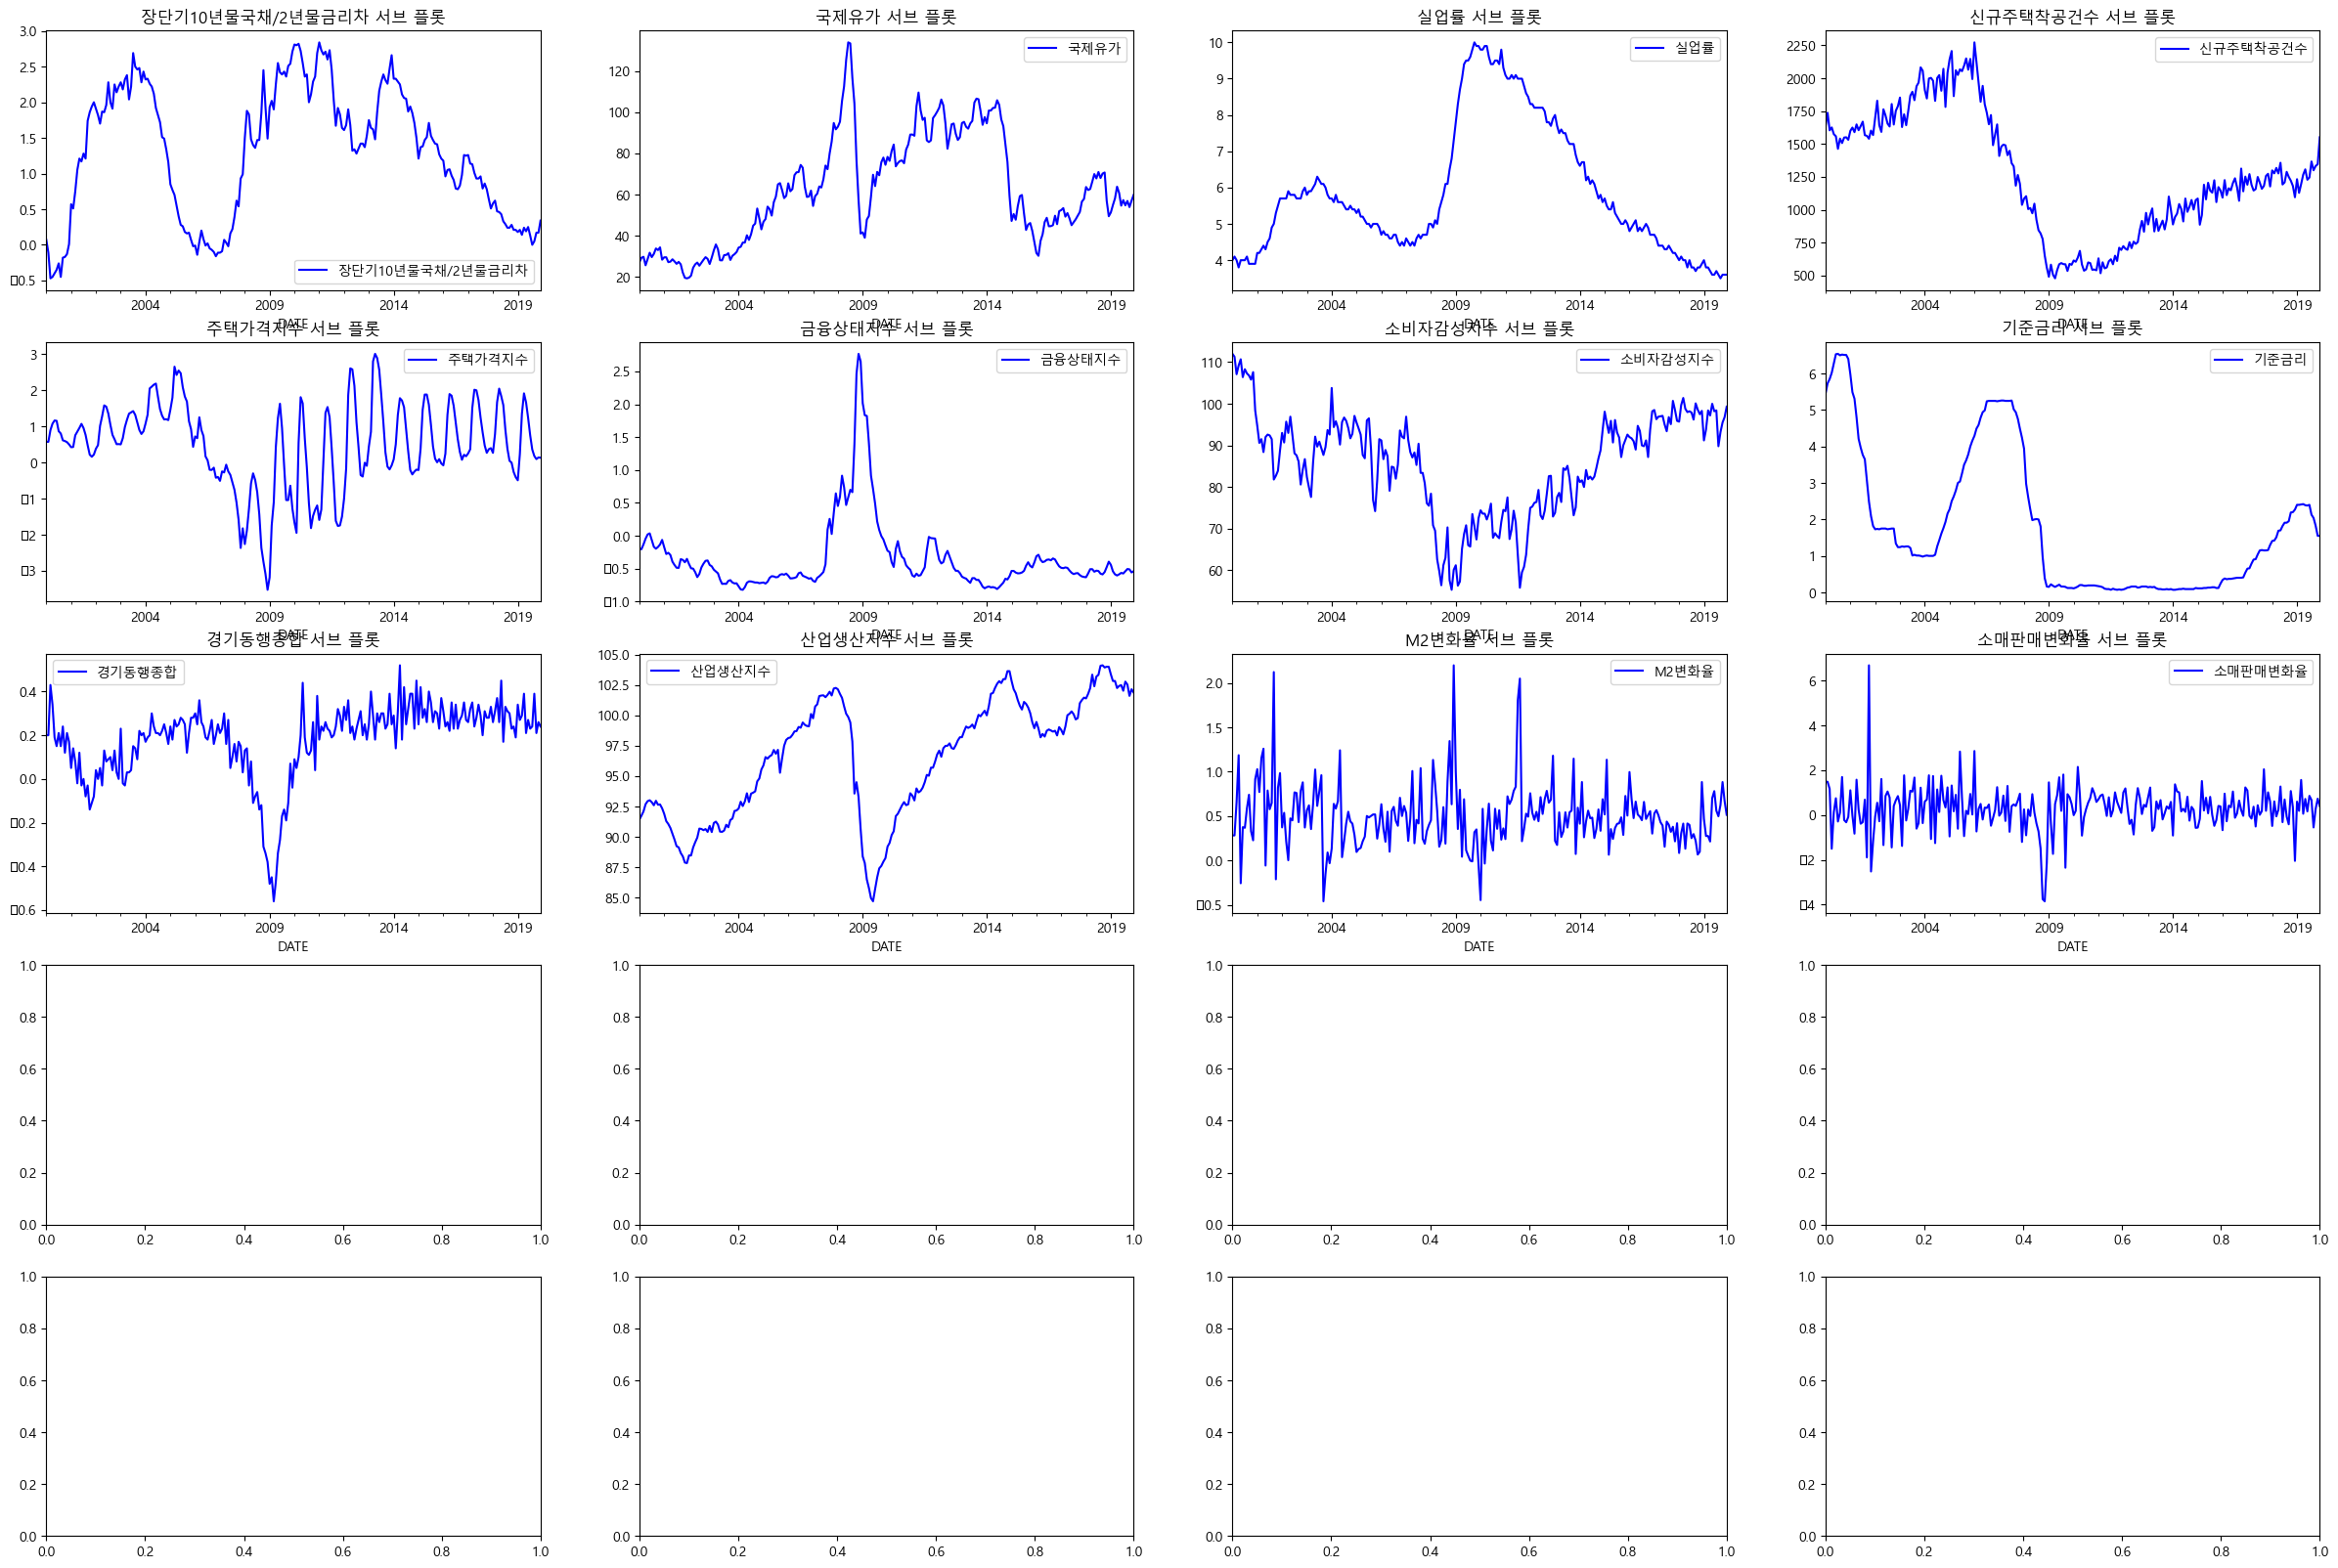

In [12]:
# 그래프 크기 조정
plt.rcParams['font.family'] ='Malgun Gothic'
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(economics.columns):
    economics.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()


#### 스케일링

1. min-max : 0~1까지인데 이건 시간적으로 상승하는데이터는
좋지 않아보임

2. StandardScaler

In [13]:
# # scikit-learn 패키지의 StandardScaler 클래스를 불러옵니다.
# from sklearn.preprocessing import StandardScaler
# # StandardScaler 객체를 생성합니다.
# standard_scaler = StandardScaler()
# # fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
# scaled_eocs = standard_scaler.fit_transform(economics)
# # 표준화가 완료된 데이터를 데이터프레임 형태로 변환합니다.
# scaled_eocs = pd.DataFrame(scaled_eocs,
#                               index=economics.index,
#                               columns=economics.columns)
# # 표준화가 잘 되었는지 데이터를 확인해봅시다.
# scaled_eocs.head()

In [14]:
# 민멕스 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaler.fit(economics)

# 데이터 변환
mMscaled_data = mMscaler.transform(economics)

# 데이터 프레임으로 저장
mMscaled_data = pd.DataFrame(data = mMscaled_data, index = economics.index , columns = economics.columns)

In [15]:
mMscaled_data

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,
2000-01-31,0.163142,0.068739,0.076923,0.645125,0.627085,0.175077,1.000000,0.831530,0.703704,0.346574,0.279060,0.506405
2000-02-29,0.108761,0.087142,0.092308,0.701393,0.627085,0.172010,0.987654,0.874807,0.703704,0.362563,0.279060,0.506405
2000-03-31,0.000000,0.091300,0.076923,0.627298,0.676664,0.192640,0.913580,0.893354,0.916667,0.380972,0.420244,0.476300
2000-04-30,0.006042,0.055314,0.046154,0.639554,0.704055,0.216616,0.950617,0.919629,0.833333,0.411371,0.619081,0.222681
2000-05-31,0.021148,0.082094,0.076923,0.611142,0.717521,0.234737,0.977072,0.958269,0.694444,0.424436,0.076356,0.377830
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.141994,0.309343,0.015385,0.495265,0.594644,0.078896,0.608466,0.318393,0.740741,0.930879,0.360217,0.429159
2019-09-30,0.157100,0.328043,0.000000,0.457939,0.566947,0.088096,0.668430,0.304482,0.879630,0.918323,0.408469,0.313010
2019-10-31,0.193353,0.301980,0.015385,0.475766,0.553940,0.086702,0.708995,0.272025,0.712963,0.870483,0.505253,0.391452


In [16]:
scale_2 =mMscaled_data.copy()

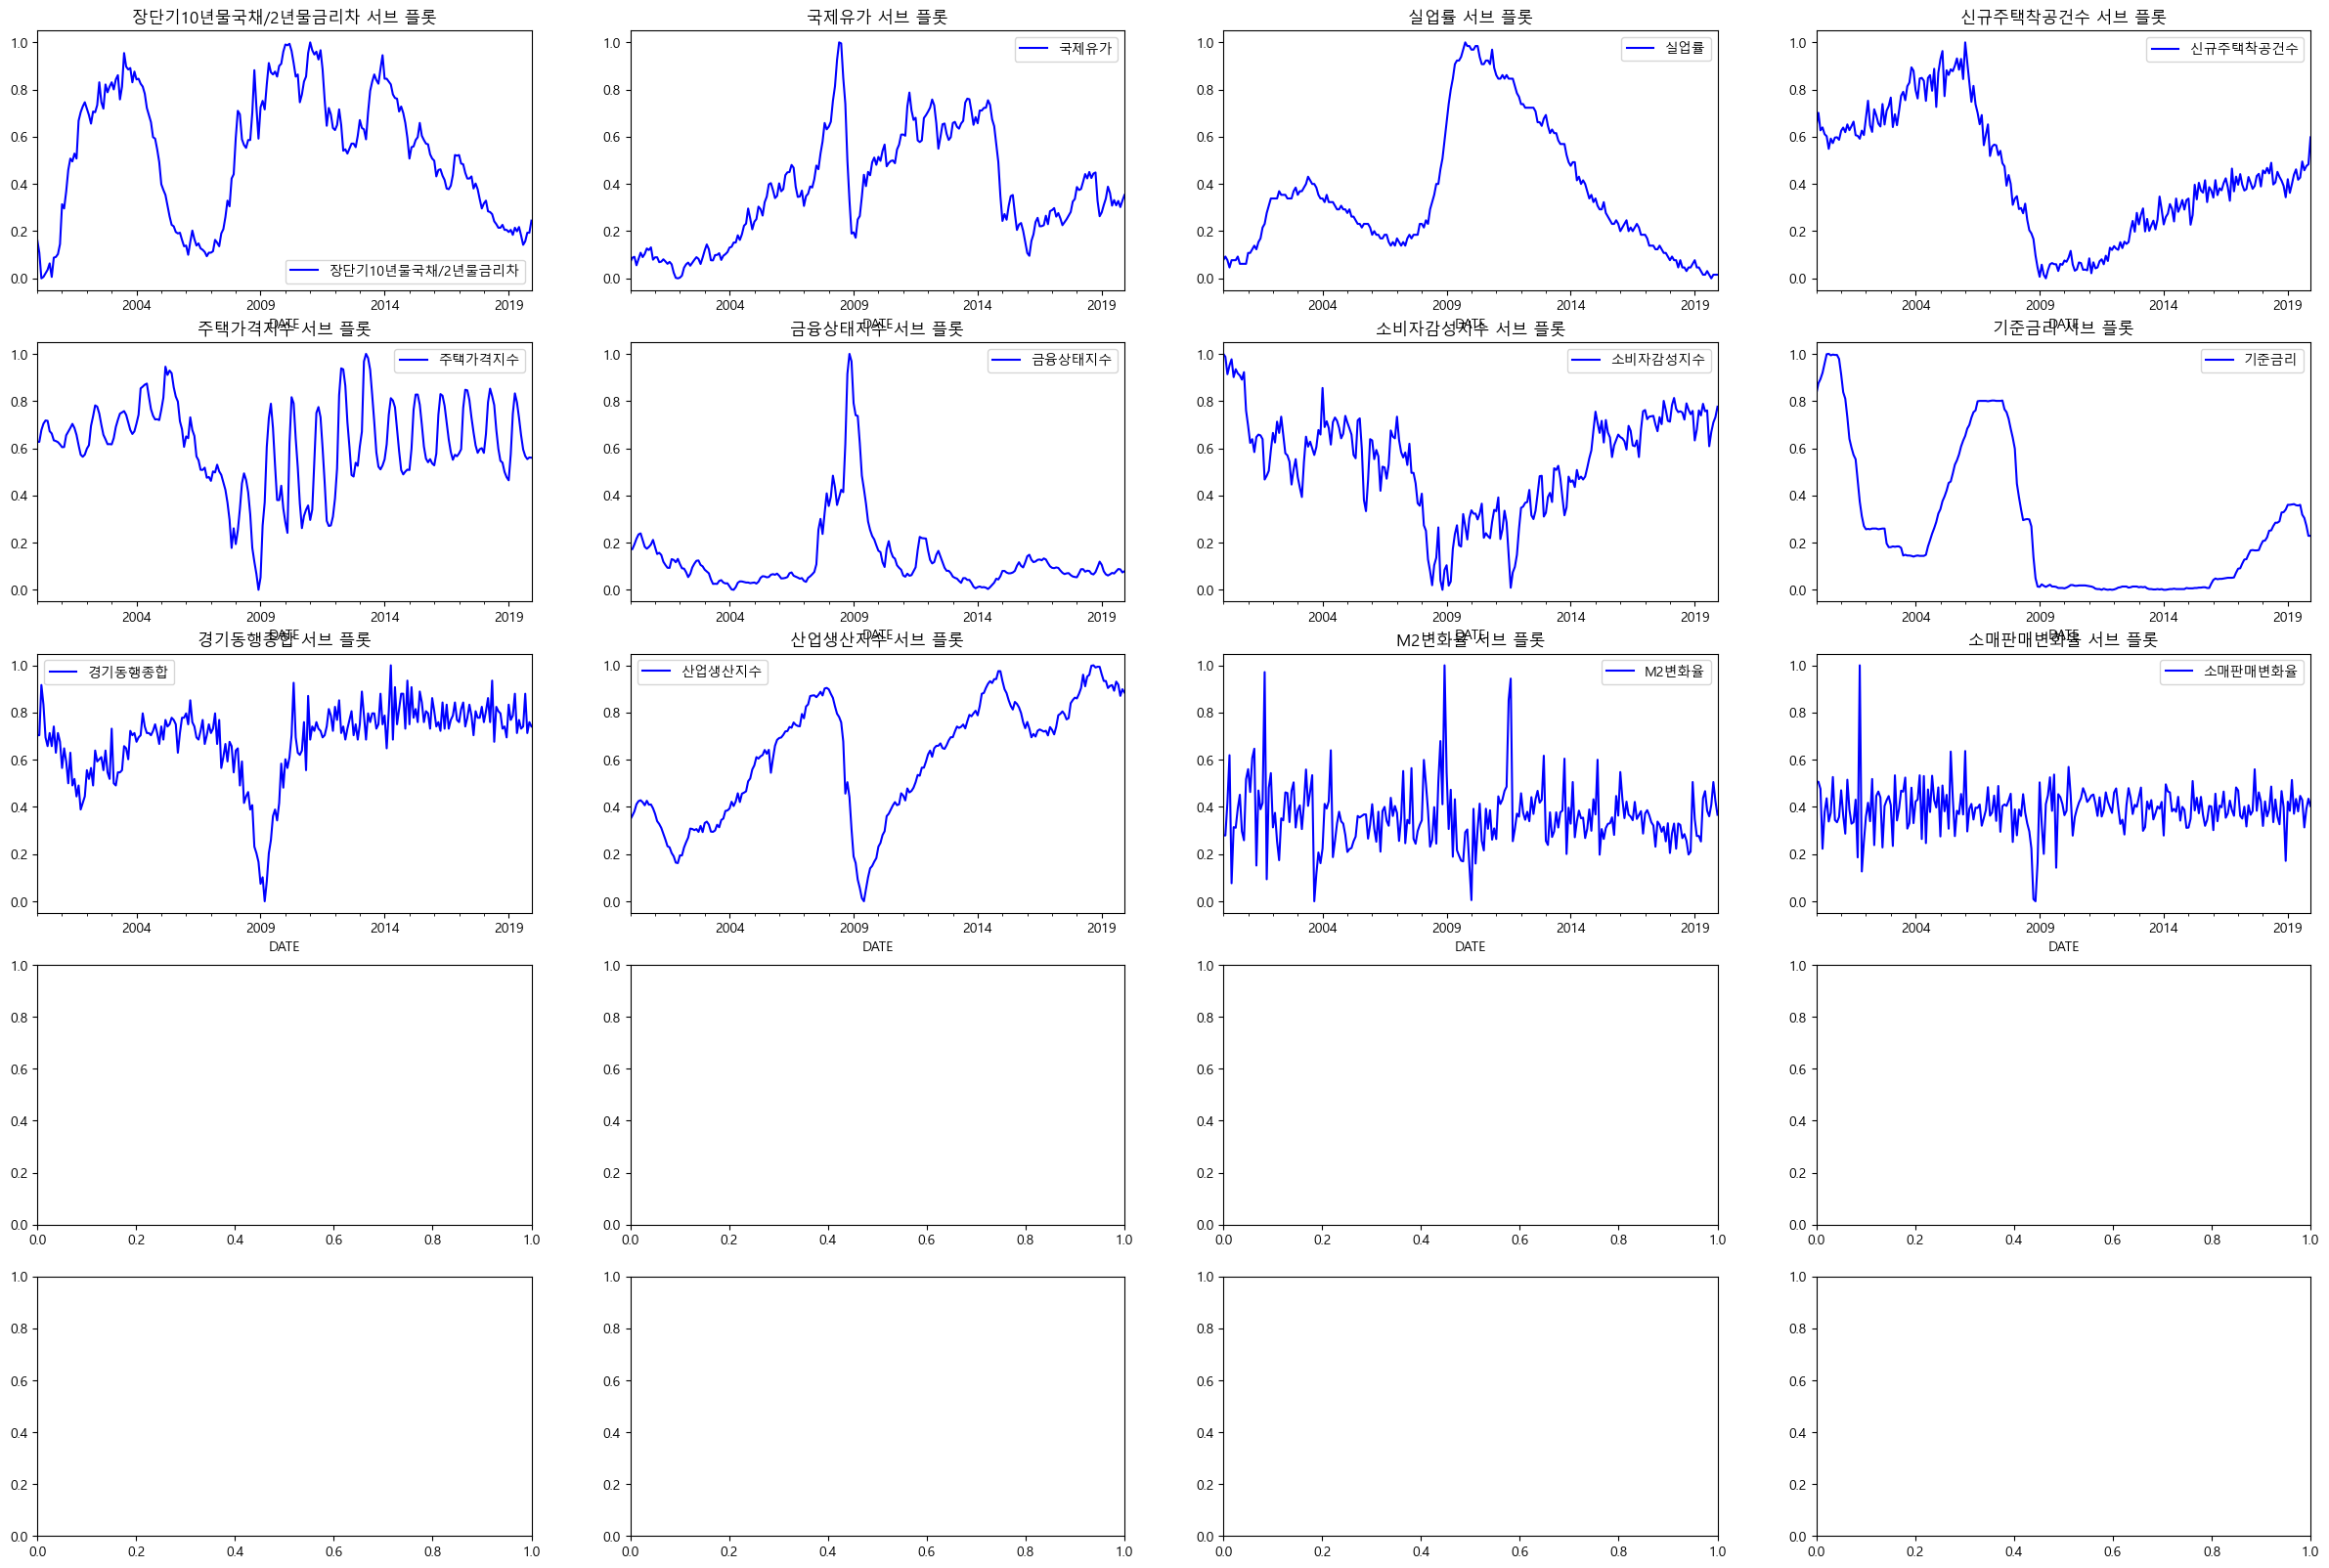

In [17]:
# 민멕스 스케일링한 데이터를 간단하게 시각화 해서 보기
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(mMscaled_data.columns):
    mMscaled_data.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D



#### KMeans

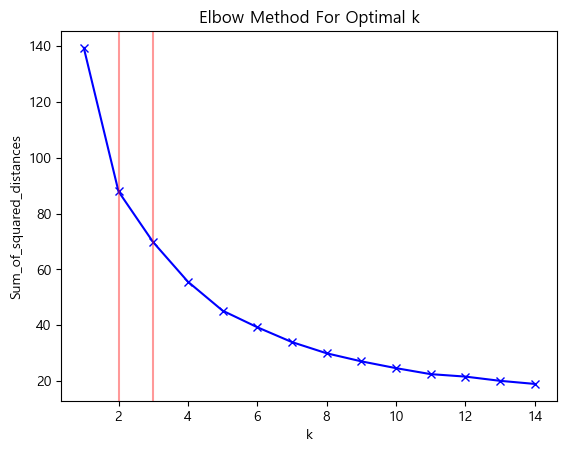

In [19]:
from sklearn.cluster import KMeans
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(mMscaled_data) # 데이터프레임 입력
    sum_of_squared_distances.append(km.inertia_)

# 시각화

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(2,c= 'r',alpha =0.4)
plt.axvline(3,c= 'r',alpha =0.4)
plt.show()

In [20]:
from sklearn.metrics import silhouette_score
k_range = range(2,14)

best_n = -1
best_silhouette_score = -1

for k in k_range:

  kmeans = KMeans(n_clusters=k, random_state=200)
  kmeans.fit(mMscaled_data)#데이터프레임
  clusters = kmeans.predict(mMscaled_data)#데이터프레임입력

  score = silhouette_score(mMscaled_data, clusters)
  print('k :',  k, 'score :', score)

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score

print('best n :', best_n, 'best score :', best_silhouette_score )

k : 2 score : 0.35880816226653034
k : 3 score : 0.28920663175356365
k : 4 score : 0.3443644703894852
k : 5 score : 0.35565654004010455
k : 6 score : 0.3726859605322396
k : 7 score : 0.38837779058216054
k : 8 score : 0.3941841974975592
k : 9 score : 0.36918959155848285
k : 10 score : 0.3786788119064118
k : 11 score : 0.3707809645101356
k : 12 score : 0.3513692963957835
k : 13 score : 0.35093704269671594
best n : 8 best score : 0.3941841974975592


In [21]:
# k = 4를 기준으로 시행하였습니다.

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import numpy as np

# KMeans
kmeans = KMeans(n_clusters=4, init="k-means++", max_iter=300, random_state=200)
kmeans.fit(mMscaled_data)

# 데이터 프레임에 cluster 추가
mMscaled_data["cluster"] = kmeans.labels_

# 개별 데이터 실루엣 계수
score_samples = silhouette_samples(mMscaled_data, mMscaled_data.cluster)
print(f'silhouette_samples( ) return 값의 shape: {score_samples.shape}')

# 데이터 프레임에 실루엣 계수 추가
mMscaled_data['silhouette_coeff'] = score_samples

# 모든 데이터의 평균 실루엣 계수
average_score = silhouette_score(mMscaled_data, mMscaled_data.cluster)
print(f'경제데이터 Silhouette Analysis Score: {average_score:.3f}')


silhouette_samples( ) return 값의 shape: (240,)
경제데이터 Silhouette Analysis Score: 0.573


In [22]:
mMscaled_data.groupby("cluster").mean()[["silhouette_coeff"]]

,silhouette_coeff
cluster,
0,0.69
1,0.46
2,0.65
3,0.54


In [23]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

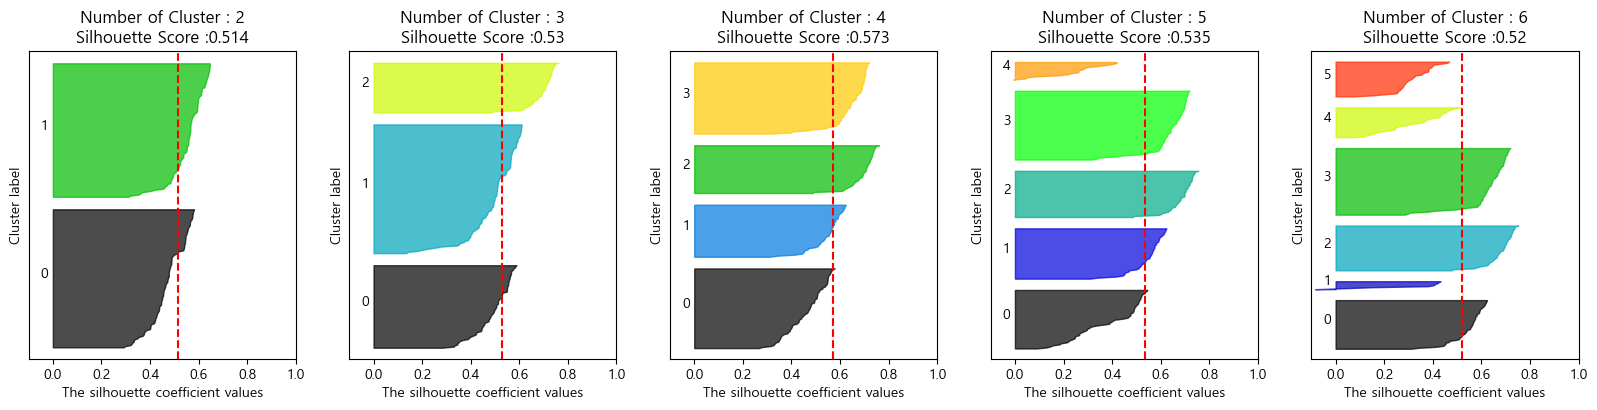

In [24]:
# 군집 개수 최적화
visualize_silhouette([ 2, 3, 4, 5 , 6], mMscaled_data)

In [25]:
# 0번 군집의 시기를 확인해봅니다.
mMscaled_data[mMscaled_data['cluster']== 3]

,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster,silhouette_coeff
DATE,,,,,,,,,,,,,,
2000-01-31,0.16,0.07,0.08,0.65,0.63,0.18,1.00,0.83,0.70,0.35,0.28,0.51,3,0.54
2000-02-29,0.11,0.09,0.09,0.70,0.63,0.17,0.99,0.87,0.70,0.36,0.28,0.51,3,0.55
2000-03-31,0.00,0.09,0.08,0.63,0.68,0.19,0.91,0.89,0.92,0.38,0.42,0.48,3,0.54
2000-04-30,0.01,0.06,0.05,0.64,0.70,0.22,0.95,0.92,0.83,0.41,0.62,0.22,3,0.51
2000-05-31,0.02,0.08,0.08,0.61,0.72,0.23,0.98,0.96,0.69,0.42,0.08,0.38,3,0.52
2000-06-30,0.04,0.11,0.08,0.60,0.72,0.24,0.90,1.00,0.66,0.43,0.31,0.44,3,0.58
2000-07-31,0.06,0.09,0.08,0.55,0.67,0.21,0.93,1.00,0.71,0.42,0.31,0.34,3,0.57
2000-08-31,0.01,0.10,0.09,0.59,0.66,0.18,0.92,0.99,0.66,0.41,0.39,0.38,3,0.58
2000-09-30,0.09,0.13,0.06,0.57,0.63,0.17,0.91,1.00,0.74,0.43,0.45,0.53,3,0.57


In [26]:
# 각 군집마다 해당되는 월의 개수를 표시해줍니다.
data_list = list(mMscaled_data['cluster'].value_counts())
for i, j  in enumerate(data_list) :
    print(f'{i}번째 클러스터 개수는 {j}개 입니다')

0번째 클러스터 개수는 76개 입니다
1번째 클러스터 개수는 68개 입니다
2번째 클러스터 개수는 50개 입니다
3번째 클러스터 개수는 46개 입니다


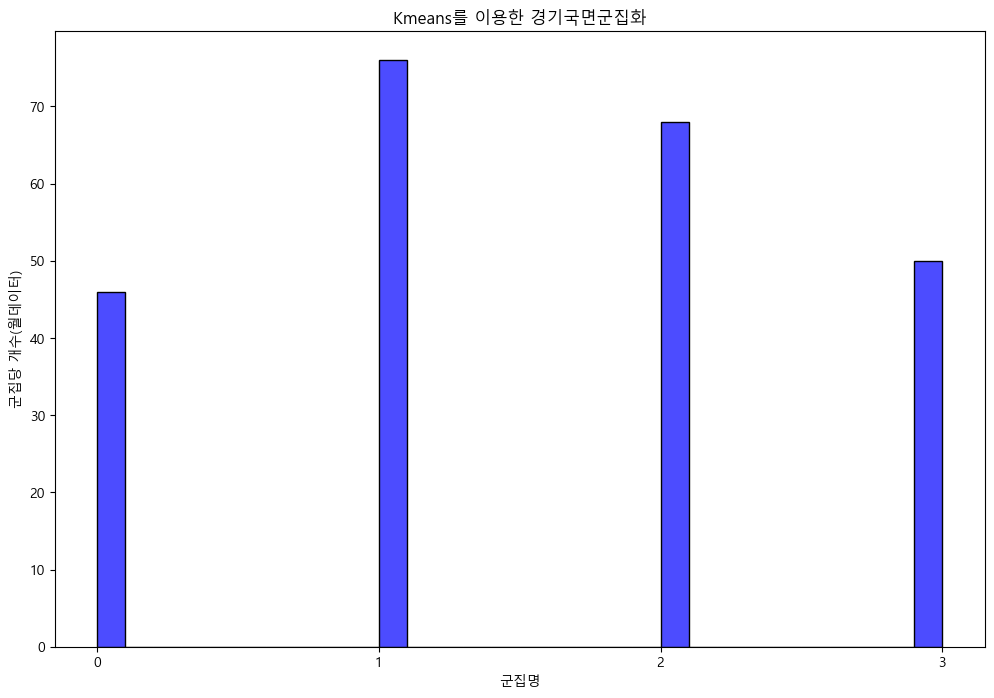

In [27]:
# k-means 군집화의 클러스터를 시각화
import matplotlib.ticker as ticker
# Seaborn 히스토그램 그리기
b=  mMscaled_data['cluster'].astype(int)


# Seaborn 히스토그램 그리기
plt.figure(figsize=(12, 8))
ax = sns.histplot(b, bins=30, kde=False, color='blue', alpha=0.7)

# x축 눈금을 정수로 바꾸는 함수
def format_func(value, tick_number):
    return int(value)

# x축 눈금에 함수 적용
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_func))

# 그래프 제목과 축 레이블 추가
plt.title('Kmeans를 이용한 경기국면군집화')
plt.xlabel('군집명')
plt.ylabel('군집당 개수(월데이터)')

# 그래프 보이기
plt.show()

#### ANOVA

In [28]:
mMscaled_data['cluster'].unique()

array([3, 0, 2, 1])

In [29]:
cluster0 = mMscaled_data[mMscaled_data['cluster']==0]
cluster1 = mMscaled_data[mMscaled_data['cluster']==1]
cluster2 = mMscaled_data[mMscaled_data['cluster']==2]
cluster3 = mMscaled_data[mMscaled_data['cluster']==3]

In [30]:
scale = mMscaled_data.copy()

In [31]:
scale = scale.reset_index()
scale.head()

,DATE,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,소비자감성지수,기준금리,경기동행종합,산업생산지수,M2변화율,소매판매변화율,cluster,silhouette_coeff
0,2000-01-31,0.16,0.07,0.08,0.65,0.63,0.18,1.00,0.83,0.70,0.35,0.28,0.51,3,0.54
1,2000-02-29,0.11,0.09,0.09,0.70,0.63,0.17,0.99,0.87,0.70,0.36,0.28,0.51,3,0.55
2,2000-03-31,0.00,0.09,0.08,0.63,0.68,0.19,0.91,0.89,0.92,0.38,0.42,0.48,3,0.54
3,2000-04-30,0.01,0.06,0.05,0.64,0.70,0.22,0.95,0.92,0.83,0.41,0.62,0.22,3,0.51
4,2000-05-31,0.02,0.08,0.08,0.61,0.72,0.23,0.98,0.96,0.69,0.42,0.08,0.38,3,0.52


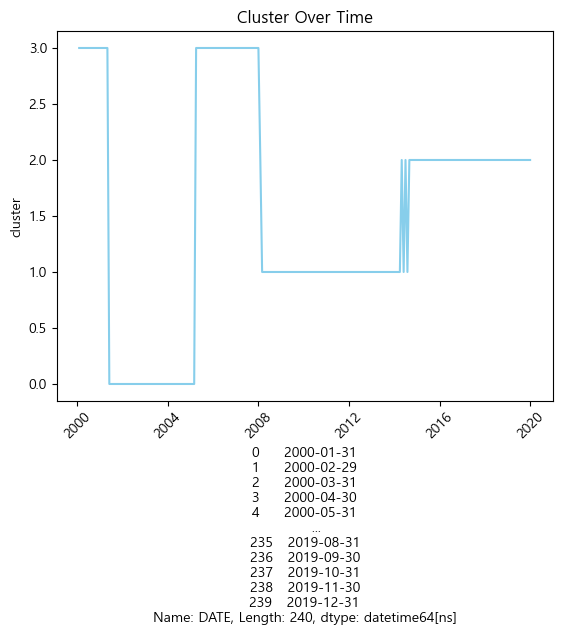

In [33]:
# 그래프 그리기
plt.plot(scale['DATE'], scale['cluster'], color='skyblue')

# 그래프 세부 설정
plt.xlabel(scale['DATE'])
plt.ylabel('cluster')
plt.title('Cluster Over Time')
plt.xticks(rotation=45)

# 그래프 표시
plt.show()


In [ ]:
# 격분기라는 뜻 (2015년~2016년)


In [29]:
mMscaled_data.columns

Index(['장단기10년물국채/2년물금리차', '국제유가', '실업률', '신규주택착공건수', '주택가격지수', '금융상태지수',
       '소비자감성지수', '기준금리', '경기동행종합', '산업생산지수', 'M2변화율', '소매판매변화율', 'cluster',
       'silhouette_coeff'],
      dtype='object')

In [30]:
mMscaled_data.drop(['silhouette_coeff'], axis=1,inplace=True)

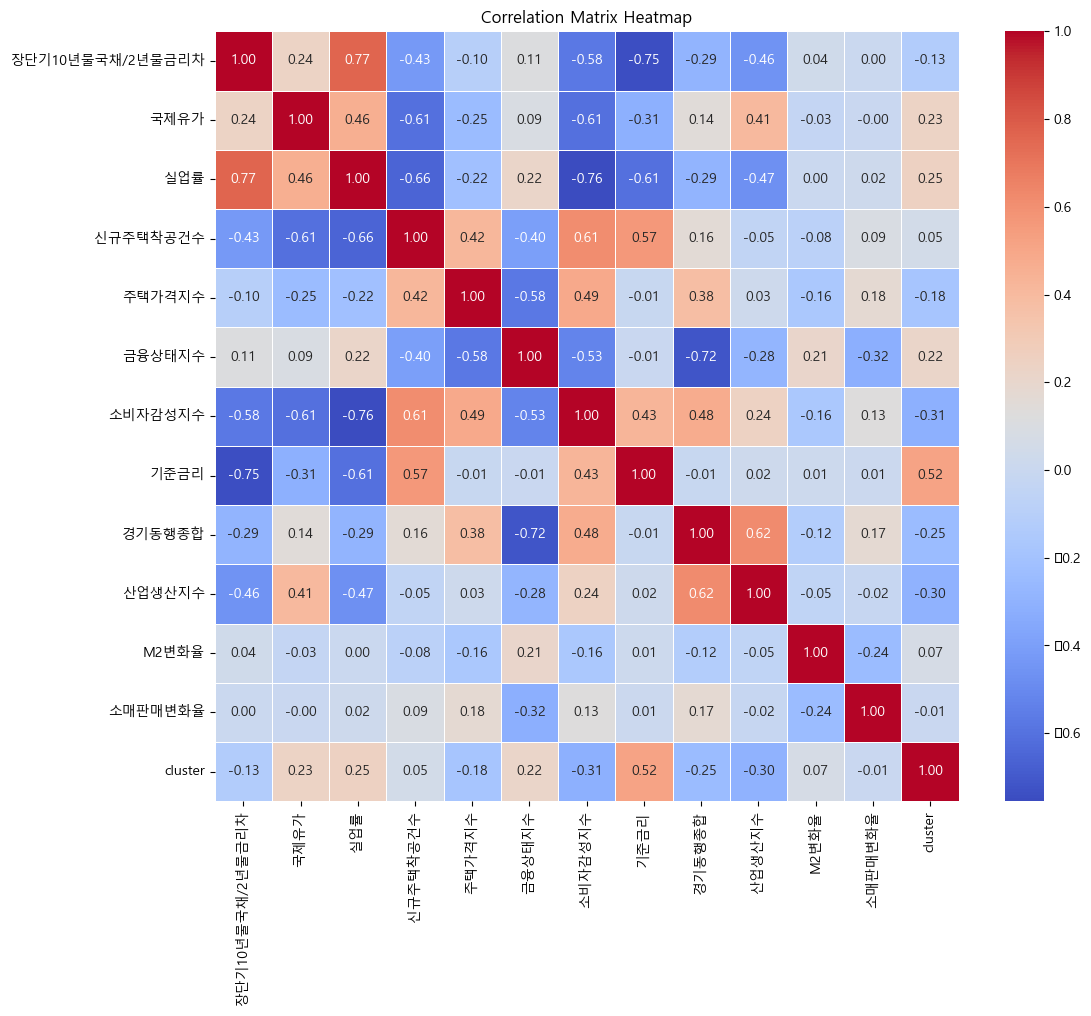

In [31]:
# 독립성 검정
import matplotlib.pyplot as plt
import seaborn as sns

# 상관 행렬 계산
correlation_matrix = mMscaled_data[mMscaled_data.columns].corr()

# 히트맵 그리기
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [32]:
# 정규성 검정 (Shapiro-Wilk)
# 귀무가설 : 정규분포를 따른다
from scipy.stats import shapiro

# 클러스터별 feature에 대해 정규성 검정 수행
for cluster_num in range(4):  # 클러스터 번호는 0부터 3까지 총 4개
    cluster_data = mMscaled_data[mMscaled_data['cluster'] == cluster_num]
    
    print(f"\nCluster {cluster_num} - Shapiro-Wilk Test:")
    for column in cluster_data.columns:
        shapiro_test = shapiro(cluster_data[column])
        if shapiro_test.pvalue >= 0.05:
            print(f"{column} - p-value: {shapiro_test.pvalue}")


Cluster 0 - Shapiro-Wilk Test:
신규주택착공건수 - p-value: 0.3191715478897095
경기동행종합 - p-value: 0.17036215960979462
M2변화율 - p-value: 0.050440192222595215
소매판매변화율 - p-value: 0.09047222882509232
cluster - p-value: 1.0

Cluster 1 - Shapiro-Wilk Test:
신규주택착공건수 - p-value: 0.07675179094076157
주택가격지수 - p-value: 0.39661338925361633
소비자감성지수 - p-value: 0.14481614530086517
경기동행종합 - p-value: 0.06658770889043808
산업생산지수 - p-value: 0.11083292216062546
cluster - p-value: 1.0

Cluster 2 - Shapiro-Wilk Test:
주택가격지수 - p-value: 0.3915657103061676
cluster - p-value: 1.0

Cluster 3 - Shapiro-Wilk Test:
신규주택착공건수 - p-value: 0.10248571634292603
주택가격지수 - p-value: 0.2271716594696045
경기동행종합 - p-value: 0.69434654712677
소매판매변화율 - p-value: 0.19222547113895416
cluster - p-value: 1.0


In [39]:
mMscaled_data2 = mMscaled_data[['신규주택착공건수' ,'경기동행종합' ,'M2변화율','소매판매변화율','주택가격지수' ,'소비자감성지수','산업생산지수','cluster' ]]

In [40]:
cluster0 = mMscaled_data2[mMscaled_data2['cluster']==0]
cluster1 = mMscaled_data2[mMscaled_data2['cluster']==1]
cluster2 = mMscaled_data2[mMscaled_data2['cluster']==2]
cluster3 = mMscaled_data2[mMscaled_data2['cluster']==3]

In [41]:
# 등분산성 검정 - 바틀렛검정
# 귀무가설 : 등분산성의 특징이 있다
from scipy.stats import bartlett

# 등분산성 검정을 수행할 데이터프레임들
dataframes = [cluster0, cluster1, cluster2, cluster3]

# 각 데이터프레임에 대해 등분산성 검정 수행
for i, cluster_data in enumerate(dataframes):
    print(f"\nCluster {i} - Bartlett's Test:")
    for column in cluster_data.columns:
        # 등분산성 검정 수행
        bartlett_test = bartlett(*[dataframe[column] for dataframe in dataframes])
        if bartlett_test.pvalue >= 0.05:
            print(f"{column} - p-value: {bartlett_test.pvalue}")



Cluster 0 - Bartlett's Test:

Cluster 1 - Bartlett's Test:

Cluster 2 - Bartlett's Test:

Cluster 3 - Bartlett's Test:


독립성, 정규성, 등분산성 검정 후 ANOVA 수행

In [42]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.formula.api import ols

for col in cluster0.columns:
    F, p = stats.f_oneway(cluster0[col],
                    cluster1[col],
                    cluster2[col],
                    cluster3[col]
                    )
    # print(col)
    # print( 'F-Ratio: {}'.format(F)
    # , 'p-value:{}'.format(p)
    #  , sep = '\n')
    if p <= 0.05:
        print(f"{col} \n F-Ratio: {F} \n p-value: {p}")

신규주택착공건수 
 F-Ratio: 391.313212152755 
 p-value: 2.807478112092715e-91
경기동행종합 
 F-Ratio: 24.12093871071218 
 p-value: 1.1888664648067024e-13
주택가격지수 
 F-Ratio: 12.169536593153037 
 p-value: 1.9650801416369555e-07
소비자감성지수 
 F-Ratio: 145.38078266180327 
 p-value: 2.2910139487493527e-53
산업생산지수 
 F-Ratio: 81.99591283541139 
 p-value: 2.242956560993653e-36
cluster 
 F-Ratio: inf 
 p-value: 0.0


In [43]:
# 위의 피쳐들이 유의미하게 나옴